### bowtie로 인덱스 생성 및 정렬 후 htseq-count로 테이블 생성한 Subacute 데이터

In [1]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 샘플 리스트 및 조건 매핑
samples = ["SRR5292045", "SRR5292046", "SRR5292047", "SRR5292048", "SRR5292049"]
conditions = ["TBI-Subacute-Control", "TBI-Subacute-Control", "TBI-Subacute", "TBI-Subacute", "TBI-Subacute"]

# 카운트 데이터를 하나의 DataFrame으로 결합
count_data = pd.DataFrame()

for sample in samples:
    sample_data = pd.read_csv(f"/data1/project/eunyi/tbi/data/bowht_counts/{sample}_counts.txt", sep="\t", header=None, index_col=0)
    
    # 메타데이터 행 제거
    sample_data = sample_data[~sample_data.index.str.startswith("__")]
    
    count_data[sample] = sample_data[1]

# gene 열을 인덱스로 설정
count_data.index.name = "ensembl ID"

# 샘플 조건을 DataFrame으로 변환
col_data = pd.DataFrame({'condition': conditions}, index=samples)
col_data['condition'] = pd.Categorical(col_data['condition'])

# DESeq2 분석 수행
dds = DeseqDataSet(counts=count_data.T, metadata=col_data, design_factors="condition", refit_cooks=True, n_cpus=8)
dds.deseq2()
deseq_stats = DeseqStats(dds)
deseq_stats.summary()

# 결과 추출 및 저장
subacute_results = deseq_stats.results_df[['log2FoldChange', 'pvalue', 'padj']]
subacute_results.columns = ["TBI Subacute vs SControl Log2 fold change", "Subacute pval", "Subacute padj"]

subacute_results.to_csv("/data1/project/eunyi/tbi/bowht_subacute_deseq2.csv")


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3.07 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

/data1/project/eunyi/envs/anaconda3/envs/deseq/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 3.07 seconds.

Fitting LFCs...
... done in 2.49 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.81 seconds.



Log2 fold change & Wald test p-value: condition TBI-Subacute-Control vs TBI-Subacute
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl ID                                                                      
ENSMUSG00000000001  3149.090131       -0.004249  0.181824 -0.023368  0.981357   
ENSMUSG00000000003     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000000028    76.909717        0.048852  0.425682  0.114763  0.908633   
ENSMUSG00000000031    22.175953       -6.060255  1.569384 -3.861550  0.000113   
ENSMUSG00000000037     4.387869       -0.645345  1.532612 -0.421075  0.673700   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000093370     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093371     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093372     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093373     0

In [2]:
# 분석 결과 데이터 불러오기
subacute_results = pd.read_csv('/data1/project/eunyi/tbi/bowht_subacute_deseq2.csv', index_col=0)

# 기준을 조정하여 목표 수치에 근접하게 함
up_regulated_criteria_subacute = (subacute_results['TBI Subacute vs SControl Log2 fold change'] > 1.00) & (subacute_results['Subacute padj'] < 0.05)
down_regulated_criteria_subacute = (subacute_results['TBI Subacute vs SControl Log2 fold change'] < -0.8) & (subacute_results['Subacute padj'] < 0.05)

subacute_up = subacute_results[up_regulated_criteria_subacute]
subacute_down = subacute_results[down_regulated_criteria_subacute]

subacute_up_count = len(subacute_up)
subacute_down_count = len(subacute_down)

print(f"Subacute Up: {subacute_up_count}")
print(f"Subacute Down: {subacute_down_count}")

Subacute Up: 22
Subacute Down: 230


In [3]:
# 분석 결과 데이터 불러오기
subacute_results = pd.read_csv('/data1/project/eunyi/tbi/bowht_subacute_deseq2.csv', index_col=0)

# 기준을 조정하여 목표 수치에 근접하게 함
up_regulated_criteria_subacute = (subacute_results['TBI Subacute vs SControl Log2 fold change'] > 0.4) & (subacute_results['Subacute padj'] < 0.22)
down_regulated_criteria_subacute = (subacute_results['TBI Subacute vs SControl Log2 fold change'] < -1.3) & (subacute_results['Subacute padj'] < 0.0002)

subacute_up = subacute_results[up_regulated_criteria_subacute]
subacute_down = subacute_results[down_regulated_criteria_subacute]

subacute_up_count = len(subacute_up)
subacute_down_count = len(subacute_down)

print(f"Adjusted Subacute Up: {subacute_up_count}")
print(f"Adjusted Subacute Down: {subacute_down_count}")

Adjusted Subacute Up: 180
Adjusted Subacute Down: 57


In [4]:
import mygene

# 1. 데이터 불러오기
file_path = "/data1/project/eunyi/tbi/bowht_subacute_deseq2.csv"
df = pd.read_csv(file_path)

# 2. mygene 인스턴스 생성
mg = mygene.MyGeneInfo()

# 3. Ensembl ID로 Gene Symbol 매핑
ensembl_ids = df['ensembl ID'].tolist()
query_results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')

# 4. 결과를 데이터프레임으로 변환
query_df = pd.DataFrame(query_results)

# 중복된 결과 처리: 중복된 ID에 대해 첫 번째 결과를 선택
query_df.drop_duplicates(subset=['query'], keep='first', inplace=True)

# 5. Gene Symbol 매핑 정보 병합
# Ensembl ID를 기준으로 기존 데이터와 병합
df_merged = pd.merge(df, query_df[['query', 'symbol']], left_on='ensembl ID', right_on='query', how='left')

# 매핑되지 않은 ID를 'unmapped'로 표시 (inplace=False를 사용하여 새로운 변수에 할당)
df_merged['symbol'] = df_merged['symbol'].fillna('unmapped')

# 필요없는 'query' 열 제거 후 'symbol' 열을 앞으로 이동
df_merged = df_merged.drop(columns=['query'])
df_merged = df_merged[['symbol'] + [col for col in df_merged.columns if col != 'symbol']]

# 결과 출력
df_merged.head()

3 input query terms found dup hits:	[('ENSMUSG00000008658', 2), ('ENSMUSG00000023809', 2), ('ENSMUSG00000086727', 2)]
6769 input query terms found no hit:	['ENSMUSG00000000325', 'ENSMUSG00000000702', 'ENSMUSG00000001379', 'ENSMUSG00000001417', 'ENSMUSG000


,symbol,ensembl ID,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj
0,Gnai3,ENSMUSG00000000001,-0.004249,0.981357,0.998485
1,Pbsn,ENSMUSG00000000003,NaN,NaN,NaN
2,Cdc45,ENSMUSG00000000028,0.048852,0.908633,0.991531
3,H19,ENSMUSG00000000031,-6.060255,0.000113,0.010768
4,Scml2,ENSMUSG00000000037,-0.645345,0.673700,NaN


In [5]:
# 'unmapped'로 표시된 항목의 개수 계산
unmapped_count = df_merged[df_merged['symbol'] == 'unmapped'].shape[0]

# 결과 출력
print(f"Number of 'unmapped' entries: {unmapped_count}")

Number of 'unmapped' entries: 6774


In [6]:
# 'unmapped'로 표시된 행을 제거
df_filtered = df_merged[df_merged['symbol'] != 'unmapped']

# 결과 출력
df_filtered

,symbol,ensembl ID,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj
0,Gnai3,ENSMUSG00000000001,-0.004249,0.981357,0.998485
1,Pbsn,ENSMUSG00000000003,NaN,NaN,NaN
2,Cdc45,ENSMUSG00000000028,0.048852,0.908633,0.991531
3,H19,ENSMUSG00000000031,-6.060255,0.000113,0.010768
4,Scml2,ENSMUSG00000000037,-0.645345,0.673700,NaN
...,...,...,...,...,...
37654,Mir3101,ENSMUSG00000093348,NaN,NaN,NaN
37657,Mir3072,ENSMUSG00000093351,-1.636198,0.738546,NaN
37660,Mir125b-1,ENSMUSG00000093354,2.684989,0.568425,NaN
37661,Snora26,ENSMUSG00000093355,NaN,NaN,NaN


In [7]:
df = df_filtered

# 'gene' 열을 제외한 데이터 열 선택
df = df.drop(columns=['ensembl ID'])
# 'symbol' 열을 'gene'으로 이름 변경
df = df.rename(columns={'symbol': 'gene'})

df.to_csv("/data1/project/eunyi/tbi/0.bowht_subacute_deseq2_gene.csv")
df

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj
0,Gnai3,-0.004249,0.981357,0.998485
1,Pbsn,NaN,NaN,NaN
2,Cdc45,0.048852,0.908633,0.991531
3,H19,-6.060255,0.000113,0.010768
4,Scml2,-0.645345,0.673700,NaN
...,...,...,...,...
37654,Mir3101,NaN,NaN,NaN
37657,Mir3072,-1.636198,0.738546,NaN
37660,Mir125b-1,2.684989,0.568425,NaN
37661,Snora26,NaN,NaN,NaN


In [8]:
df['Subacute-log10(p_value)'] = -np.log10(df['Subacute pval'])
df['Subacute-log10(padj)'] = -np.log10(df['Subacute padj'])

In [9]:
df.dropna(inplace=True)

In [10]:
df.columns

Index(['gene', 'TBI Subacute vs SControl Log2 fold change', 'Subacute pval',
       'Subacute padj', 'Subacute-log10(p_value)', 'Subacute-log10(padj)'],
      dtype='object')

In [11]:
df_subacute = df
df_subacute

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj)
0,Gnai3,-0.004249,0.981357,0.998485,0.008173,0.000659
2,Cdc45,0.048852,0.908633,0.991531,0.041611,0.003694
3,H19,-6.060255,0.000113,0.010768,3.948192,1.967884
6,Narf,-0.041851,0.849998,0.986401,0.070582,0.005947
7,Cav2,0.270668,0.196677,0.770430,0.706246,0.113267
...,...,...,...,...,...,...
37403,Mir3097,0.581393,0.607398,0.949260,0.216527,0.022615
37446,Mir28b,-0.180842,0.824064,0.981962,0.084039,0.007905
37453,Gm23369,0.196796,0.845287,0.985728,0.072996,0.006243
37583,Gm26236,-0.040380,0.897184,0.989398,0.047118,0.004629


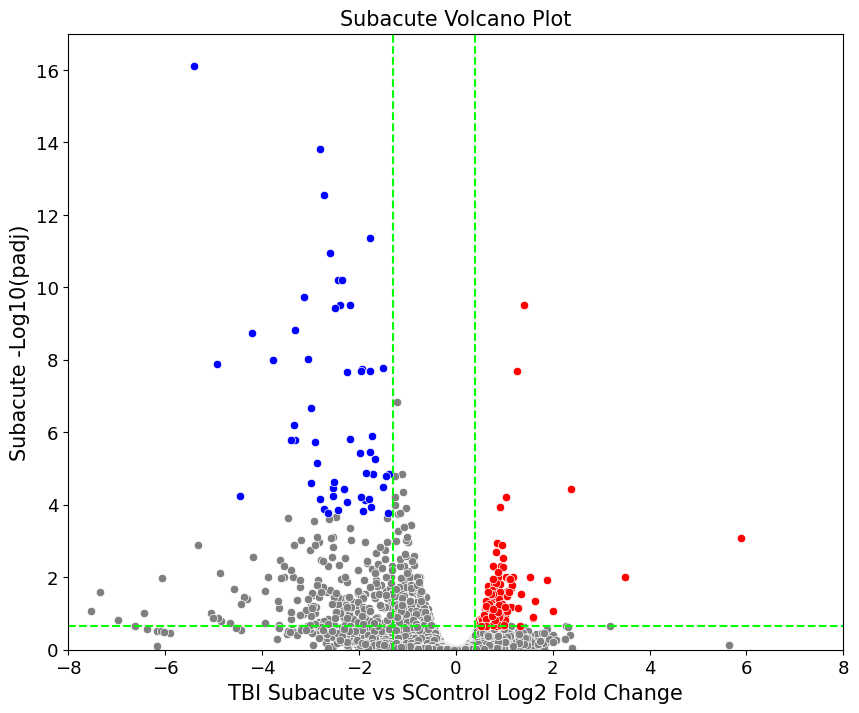

In [33]:
# 조건에 따른 색상 지정
df_subacute['color'] = 'gray'  # 기본 색상
df_subacute.loc[(df_subacute['Subacute padj'] < 0.22) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] > 0.4), 'color'] = 'red'
df_subacute.loc[(df_subacute['Subacute padj'] < 0.0002) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] < -1.3), 'color'] = 'blue'

# Volcano plot
plt.figure(figsize=(10, 8))
# sns.scatterplot(data=df_subacute, x='TBI Subacute vs SControl Log2 fold change', y='Subacute-log10(p_value)', c=df_subacute['color'])

# 회색 데이터 포인트 그리기
sns.scatterplot(data=df_subacute[df_subacute['color'] == 'gray'], x='TBI Subacute vs SControl Log2 fold change', y='Subacute-log10(padj)', color='gray')
# 파란색 데이터 포인트 그리기
sns.scatterplot(data=df_subacute[df_subacute['color'] == 'red'], x='TBI Subacute vs SControl Log2 fold change', y='Subacute-log10(padj)', color='red')
sns.scatterplot(data=df_subacute[df_subacute['color'] == 'blue'], x='TBI Subacute vs SControl Log2 fold change', y='Subacute-log10(padj)', color='blue')
plt.xlim(-8, 8)
plt.ylim(0, 17) 


# 임계값 선 추가
plt.axhline(y=-np.log10(0.22), color='lime', linestyle='--')  # p-value 임계값 (예: 0.05)
plt.axvline(x=0.4, color='lime', linestyle='--')  # fold change 임계값 (예: 1)
plt.axvline(x=-1.3, color='lime', linestyle='--')  # fold change 임계값 (예: -1)


# 축 레이블과 제목 추가
plt.xlabel('TBI Subacute vs SControl Log2 Fold Change', fontsize=15)
plt.ylabel('Subacute -Log10(padj)', fontsize=15)
plt.title('Subacute Volcano Plot', fontsize=15)

# 축 눈금 폰트 크기 설정
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# 출력
plt.show()

In [12]:
# Red로 표시된 데이터 포인트의 개수
red_count = df_subacute[(df_subacute['Subacute padj'] < 0.22) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] > 0.4)].shape[0]

# Blue로 표시된 데이터 포인트의 개수
blue_count = df_subacute[(df_subacute['Subacute padj'] < 0.0002) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] < -1.3)].shape[0]

# 결과 출력
print(f"Red points count: {red_count}")
print(f"Blue points count: {blue_count}")


Red points count: 173
Blue points count: 56


In [12]:
df_subacute_up = df_subacute[(df_subacute['Subacute padj'] < 0.22)  & (df_subacute['TBI Subacute vs SControl Log2 fold change'] > 0.4)]
df_subacute_up

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj)
59,Alox12,0.658976,0.007463,0.192069,2.127077,0.716542
141,Car4,0.713462,0.000225,0.017646,3.647480,1.753358
153,Dbh,5.894632,0.000005,0.000845,5.328697,3.073064
178,Icam2,0.601700,0.003127,0.109627,2.504926,0.960082
258,Cyp51,0.836614,0.000593,0.034730,3.227031,1.459295
...,...,...,...,...,...,...
28992,Gm16418,0.866763,0.002315,0.089485,2.635381,1.048252
29148,Gm12040,1.328665,0.009237,0.215124,2.034448,0.667310
34139,Gm15946,1.090595,0.000386,0.025665,3.412903,1.590663
35868,Gm6665,0.768234,0.001819,0.075044,2.740050,1.124681


In [13]:
df_subacute_down = df_subacute[(df_subacute['Subacute padj'] < 0.0002)  & (df_subacute['TBI Subacute vs SControl Log2 fold change'] < -1.3)]
df_subacute_down

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj)
176,S100a6,-2.243927,3.432069e-11,2.151633e-08,10.464444,7.667232
267,Col1a1,-2.174308,3.090623e-09,1.562559e-06,8.509954,5.806164
679,Cacna1e,-1.496181,2.177658e-11,1.706521e-08,10.662010,7.767888
805,Cd44,-1.877687,2.798390e-07,7.433757e-05,6.553092,4.128792
965,Fblim1,-1.917497,6.333392e-07,1.459754e-04,6.198364,3.835720
1002,Adamts4,-2.189989,2.208396e-13,2.995081e-10,12.655923,9.523591
1408,Kif11,-2.531327,1.085817e-07,3.545417e-05,6.964244,4.450333
1443,Aldh1a2,-1.770727,7.658159e-09,3.429324e-06,8.115876,5.464792
2467,Hmmr,-4.921674,1.581153e-11,1.304285e-08,10.801026,7.884628
2510,Upp1,-2.537047,1.903680e-07,5.647493e-05,6.720406,4.248144


In [14]:
subacute_up_list = df_subacute_up['gene'].to_list()
subacute_down_list = df_subacute_down['gene'].to_list()

In [16]:
with open('0.adjusted_subacute_up_deg_list.txt', 'w') as file:
    for item in subacute_up_list:
        file.write(f"{item}\n")

with open('0.adjusted_subacute_down_deg_list.txt', 'w') as file:
    for item in subacute_down_list:
        file.write(f"{item}\n")

In [15]:
up_deg = df_subacute[(df_subacute['Subacute padj'] < 0.22) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] > 0.4)]
down_deg = df_subacute[(df_subacute['Subacute padj'] < 0.0002) & (df_subacute['TBI Subacute vs SControl Log2 fold change'] < -1.3)]
output_up = pd.read_csv('0.adjusted_subacute_up.txt', sep='\t', header=None, names=['gene', 'score'])
output_down = pd.read_csv('0.adjusted_subacute_down.txt', sep='\t', header=None, names=['gene', 'score'])
print(len(up_deg))
print(len(down_deg))

merged_up = up_deg.merge(output_up, left_on='gene', right_on='gene')
merged_down = down_deg.merge(output_down, left_on='gene', right_on='gene')

merged_up

173
56


,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj),score
0,Alox12,0.658976,0.007463,0.192069,2.127077,0.716542,0.010011
1,Dbh,5.894632,0.000005,0.000845,5.328697,3.073064,0.010009
2,Icam2,0.601700,0.003127,0.109627,2.504926,0.960082,0.010074
3,Cyp51,0.836614,0.000593,0.034730,3.227031,1.459295,0.010035
4,Nherf2,0.485697,0.005427,0.154390,2.265440,0.811381,0.010118
...,...,...,...,...,...,...,...
76,Cebpd,0.752518,0.003194,0.110657,2.495663,0.956020,0.010000
77,Tuba1a,0.683995,0.001064,0.053454,2.973018,1.272020,0.010000
78,S100a16,0.513415,0.009520,0.218494,2.021357,0.660561,0.010000
79,Selenom,0.819401,0.004975,0.147078,2.303239,0.832453,0.010000


In [22]:
up_deg.head(10)

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj)
59,Alox12,0.658976,0.007463,0.192069,2.127077,0.716542
141,Car4,0.713462,0.000225,0.017646,3.647480,1.753358
153,Dbh,5.894632,0.000005,0.000845,5.328697,3.073064
178,Icam2,0.601700,0.003127,0.109627,2.504926,0.960082
258,Cyp51,0.836614,0.000593,0.034730,3.227031,1.459295
328,Septin7,0.599211,0.004637,0.140372,2.333745,0.852720
332,Aif1l,0.561128,0.004156,0.130786,2.381361,0.883438
444,Nherf2,0.485697,0.005427,0.154390,2.265440,0.811381
496,Timmdc1,0.918632,0.007071,0.184705,2.150523,0.733522
513,Bcam,0.504488,0.009178,0.215124,2.037246,0.667310


In [33]:
down_deg.head(10)

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj)
176,S100a6,-2.243927,3.432069e-11,2.151633e-08,10.464444,7.667232
267,Col1a1,-2.174308,3.090623e-09,1.562559e-06,8.509954,5.806164
679,Cacna1e,-1.496181,2.177658e-11,1.706521e-08,10.662010,7.767888
805,Cd44,-1.877687,2.798390e-07,7.433757e-05,6.553092,4.128792
965,Fblim1,-1.917497,6.333392e-07,1.459754e-04,6.198364,3.835720
1002,Adamts4,-2.189989,2.208396e-13,2.995081e-10,12.655923,9.523591
1408,Kif11,-2.531327,1.085817e-07,3.545417e-05,6.964244,4.450333
1443,Aldh1a2,-1.770727,7.658159e-09,3.429324e-06,8.115876,5.464792
2467,Hmmr,-4.921674,1.581153e-11,1.304285e-08,10.801026,7.884628
2510,Upp1,-2.537047,1.903680e-07,5.647493e-05,6.720406,4.248144


In [16]:
# 병합 후 누락된 유전자 찾기
merged_up_left = up_deg.merge(output_up, how='left', left_on='gene', right_on='gene')

# 병합되지 않은 유전자 (score 값이 NaN인 경우가 병합되지 않은 경우)
missing_genes_up = merged_up_left[merged_up_left['score'].isna()]
print("병합되지 않은 유전자 개수:", len(missing_genes_up))
missing_genes_up['gene']


병합되지 않은 유전자 개수: 92


1         Car4
5      Septin7
6        Aif1l
10      Rabac1
13        Ctse
        ...   
168    Gm16418
169    Gm12040
170    Gm15946
171     Gm6665
172    Snora24
Name: gene, Length: 92, dtype: object

In [21]:
merged_up.to_csv("/data1/project/eunyi/tbi/0.subacute_up_gene_np.csv")
subacute_up_gene_np = pd.read_csv("/data1/project/eunyi/tbi/0.subacute_up_gene_np.csv")
subacute_up_gene_np = subacute_up_gene_np[["gene", "score"]]
subacute_up_gene_np = subacute_up_gene_np.rename(columns={"score": "np_score"})
subacute_up_gene_np.to_csv("/data1/project/eunyi/tbi/0.subacute_up_gene_np.csv", index=False)
subacute_up_gene_np.head(10)

,gene,np_score
0,Alox12,0.010011
1,Dbh,0.010009
2,Icam2,0.010074
3,Cyp51,0.010035
4,Nherf2,0.010118
5,Timmdc1,0.010023
6,Bcam,0.010000
7,Fcgrt,0.010000
8,Rps11,0.010005
9,Slc4a1,0.010042


In [24]:
merged_down

,gene,TBI Subacute vs SControl Log2 fold change,Subacute pval,Subacute padj,Subacute-log10(p_value),Subacute-log10(padj),score
0,S100a6,-2.243927,3.432069e-11,2.151633e-08,10.464444,7.667232,0.010069
1,Col1a1,-2.174308,3.090623e-09,1.562559e-06,8.509954,5.806164,0.010078
2,Cacna1e,-1.496181,2.177658e-11,1.706521e-08,10.662010,7.767888,0.010000
3,Cd44,-1.877687,2.798390e-07,7.433757e-05,6.553092,4.128792,0.010124
4,Fblim1,-1.917497,6.333392e-07,1.459754e-04,6.198364,3.835720,0.010000
5,Kif11,-2.531327,1.085817e-07,3.545417e-05,6.964244,4.450333,0.010000
6,Aldh1a2,-1.770727,7.658159e-09,3.429324e-06,8.115876,5.464792,0.010000
7,Hmmr,-4.921674,1.581153e-11,1.304285e-08,10.801026,7.884628,0.010044
8,Upp1,-2.537047,1.903680e-07,5.647493e-05,6.720406,4.248144,0.010000
9,Itgb3,-1.502784,9.858822e-08,3.287603e-05,7.006175,4.483121,0.010155


In [31]:
merged_down.to_csv("/data1/project/eunyi/tbi/0.subacute_down_gene_np.csv")
subacute_down_gene_np = pd.read_csv("/data1/project/eunyi/tbi/0.subacute_down_gene_np.csv")
subacute_down_gene_np = subacute_down_gene_np[["gene", "score"]]
subacute_down_gene_np = subacute_down_gene_np.rename(columns={"score": "np_score"})
subacute_down_gene_np.to_csv("/data1/project/eunyi/tbi/0.subacute_down_gene_np.csv", index=False)
subacute_down_gene_np.head(10)


,gene,np_score
0,S100a6,0.010069
1,Col1a1,0.010078
2,Cacna1e,0.010000
3,Cd44,0.010124
4,Fblim1,0.010000
5,Kif11,0.010000
6,Aldh1a2,0.010000
7,Hmmr,0.010044
8,Upp1,0.010000
9,Itgb3,0.010155


In [32]:
# 병합 후 누락된 유전자 찾기
merged_down_left = down_deg.merge(output_down, how='left', left_on='gene', right_on='gene')

# 병합되지 않은 유전자 (score 값이 NaN인 경우가 병합되지 않은 경우)
missing_genes_down = merged_down_left[merged_down_left['score'].isna()]
print("병합되지 않은 유전자 개수:", len(missing_genes_down))
missing_genes_down['gene']


병합되지 않은 유전자 개수: 19


5           Adamts4
10            Prr11
15          Slc38a1
25           Tnfsf8
26              Tnc
28            Pcdh7
31             Elf4
33          Adamts8
36          Slco2a1
37            Rab6b
42             Lrg1
44             Fgl2
45            Ildr2
48             Myof
50          Plekho2
52           Adam12
53           Pdlim1
54             Nnat
55    2610035D17Rik
Name: gene, dtype: object

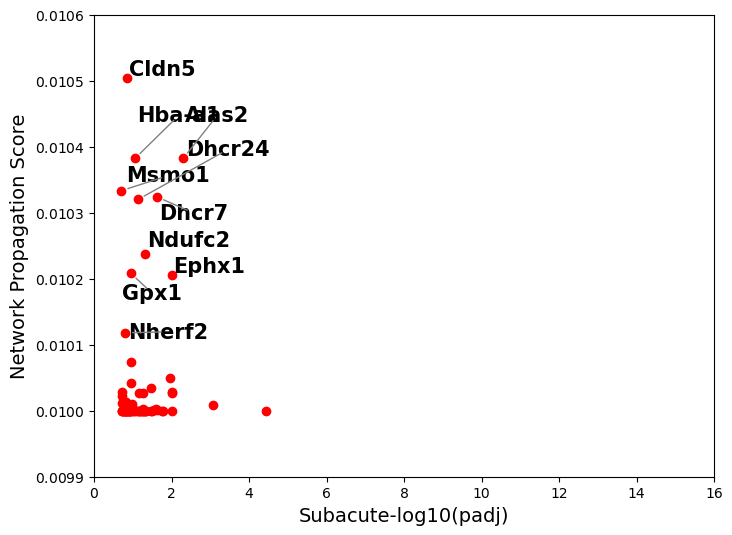

In [54]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 6))
plt.scatter(merged_up['Subacute-log10(padj)'], merged_up['score'], color='red')

# x축과 y축 레이블 설정
plt.xlabel('Subacute-log10(padj)', fontsize=14)
plt.ylabel('Network Propagation Score', fontsize=14)

# # x축과 y축 범위 통일
plt.xlim(0, 16)

# 공통 y축 범위 설정
y_min = 0.0099
y_max = 0.0106

# y축 범위 설정
plt.ylim(y_min, y_max)

# y축 눈금 설정
# plt.yticks(np.arange(y_min, y_max + 0.0001, 0.0001))

# y축 숫자 형식 설정 (지수 표기법 비활성화)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='y')  # 지수 표기법 비활성화
ax.yaxis.get_major_formatter().set_useOffset(False)

# 상위 10개 유전자에 라벨 추가
top_genes = merged_up.nlargest(10, 'score')
texts = []

for i, row in top_genes.iterrows():
    texts.append(plt.text(row['Subacute-log10(padj)'], row['score'], row['gene'], 
                          fontsize=15, color='black', fontweight='bold'))

# 텍스트 간격 자동 조정 및 화살표 조정
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', shrinkA=5, shrinkB=5), 
            only_move={'points':'y', 'text':'y'},  # y축 방향으로만 이동 허용
            expand_text=(1.5, 1.5),  # 텍스트와 포인트 간의 간격 조정
            force_text=(0.5, 0.5))  # 텍스트를 더 강하게 이동시킴

plt.show()




In [42]:
merged_up[merged_up['score'] >= 0.01]['gene']

0      Alox12
1         Dbh
2       Icam2
3       Cyp51
4      Nherf2
       ...   
65       Jund
66      Cebpd
67     Tuba1a
68    Selenom
69      Ly6c1
Name: gene, Length: 70, dtype: object

In [43]:
merged_up[merged_up['score'] >= 0.01]['gene'].tolist()

['Alox12',
 'Dbh',
 'Icam2',
 'Cyp51',
 'Nherf2',
 'Timmdc1',
 'Fcgrt',
 'Slc4a1',
 'Bcl2l1',
 'Rplp1',
 'Dynll1',
 'Srp14',
 'Rpl15',
 'Dnajb9',
 'Ppp1cb',
 'Med28',
 'Fis1',
 'Ptprr',
 'Id2',
 'Vti1b',
 'Degs2',
 'Marveld2',
 'Hes1',
 'Atf1',
 'Mospd1',
 'Bsg',
 'Banf1',
 'Alas2',
 'Ube3a',
 'Hprt1',
 'Ube2l6',
 'Cst3',
 'Edn3',
 'Map1lc3a',
 'Rnf11',
 'Arpc3',
 'Mfge8',
 'Ndufc2',
 'Msmo1',
 'Map1lc3b',
 'Gng11',
 'Mgll',
 'Dhcr24',
 'Eif1',
 'Isg15',
 'Ephx1',
 'Bpgm',
 'Blvrb',
 'Cldn5',
 'Selenow',
 'Cox6a1',
 'Selenok',
 'Uqcrq',
 'Cd24a',
 'Vamp8',
 'Rap1b',
 'Dsp',
 'Gstm1',
 'Dhcr7',
 'Pop5',
 'Gpx1',
 'ND6',
 'Lsm14a',
 'Hba-a2',
 'Hba-a1',
 'Jund',
 'Cebpd',
 'Tuba1a',
 'Selenom',
 'Ly6c1']

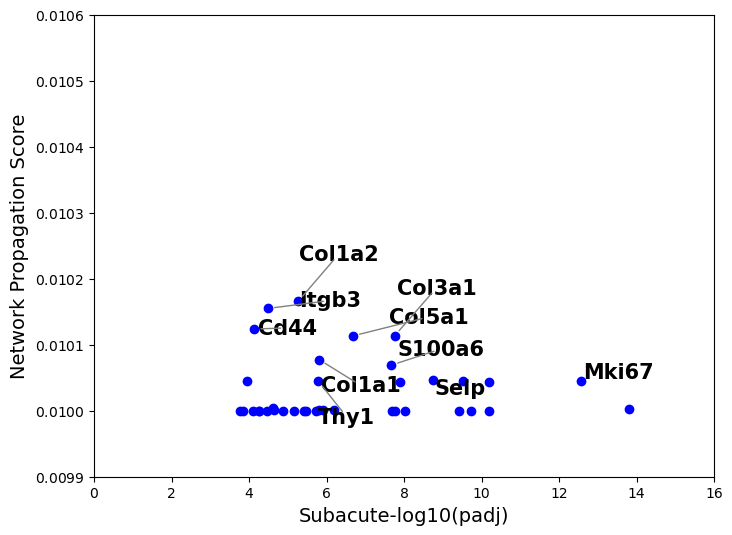

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_down['Subacute-log10(padj)'], merged_down['score'], color='blue')

# x축과 y축 레이블 설정
plt.xlabel('Subacute-log10(padj)', fontsize=14)
plt.ylabel('Network Propagation Score', fontsize=14)

# # x축과 y축 범위 통일
plt.xlim(0, 16)

# 공통 y축 범위 설정
y_min = 0.0099
y_max = 0.0106

# y축 범위 설정
plt.ylim(y_min, y_max)

# # y축 눈금 설정
# plt.yticks(np.arange(y_min, y_max + 0.0001, 0.0001))

# y축 숫자 형식 설정 (지수 표기법 비활성화)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='y')  # 지수 표기법 비활성화
ax.yaxis.get_major_formatter().set_useOffset(False)

# 상위 10개 유전자에 라벨 추가
top_genes = merged_down.nlargest(10, 'score')
texts = []

for i, row in top_genes.iterrows():
    texts.append(plt.text(row['Subacute-log10(padj)'], row['score'], row['gene'], 
                          fontsize=15, color='black', fontweight='bold'))

# 텍스트 간격 자동 조정 및 화살표 조정
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', shrinkA=5, shrinkB=5), 
            only_move={'points':'y', 'text':'y'},  # y축 방향으로만 이동 허용
            expand_text=(1.5, 1.5),  # 텍스트와 포인트 간의 간격 조정
            force_text=(0.5, 0.5))  # 텍스트를 더 강하게 이동시킴

plt.show()

In [55]:
merged_down[merged_down['score'] >= 0.01]['gene'].tolist()

['S100a6',
 'Col1a1',
 'Cacna1e',
 'Cd44',
 'Fblim1',
 'Kif11',
 'Aldh1a2',
 'Hmmr',
 'Upp1',
 'Itgb3',
 'Top2a',
 'Vcan',
 'Pbk',
 'Cyp1b1',
 'Col3a1',
 'Igfbp5',
 'Selp',
 'Sele',
 'Cenpf',
 'Col5a1',
 'Tpx2',
 'Ccna2',
 'Tnfrsf9',
 'Col1a2',
 'Mki67',
 'Cdh13',
 'Thy1',
 'Ptgs2',
 'Aspm',
 'Cd276',
 'Anln',
 'Inhbb',
 'Atp8b1',
 'Cenpe',
 'Cd109',
 'Ch25h',
 'Cd14']

### bowtie로 인덱스 생성 및 정렬 후 htseq-count로 테이블 생성한 Acute 데이터

In [2]:
# 샘플 리스트 및 조건 매핑
samples = ["SRR5292039", "SRR5292040", "SRR5292041", "SRR5292042", "SRR5292043", "SRR5292044"]
conditions = ["TBI-Acute-Control", "TBI-Acute-Control", "TBI-Acute-Control", "TBI-Acute", "TBI-Acute", "TBI-Acute"]

# 카운트 데이터를 하나의 DataFrame으로 결합
count_data = pd.DataFrame()

for sample in samples:
    sample_data = pd.read_csv(f"/data1/project/eunyi/tbi/data/bowht_counts/{sample}_counts.txt", sep="\t", header=None, index_col=0)
    
    # 메타데이터 행 제거
    sample_data = sample_data[~sample_data.index.str.startswith("__")]
    
    count_data[sample] = sample_data[1]

# gene 열을 인덱스로 설정
count_data.index.name = "ensembl ID"

# 샘플 조건을 DataFrame으로 변환
col_data = pd.DataFrame({'condition': conditions}, index=samples)
col_data['condition'] = pd.Categorical(col_data['condition'])

# DESeq2 분석 수행
dds = DeseqDataSet(counts=count_data.T, metadata=col_data, design_factors="condition", refit_cooks=True, n_cpus=8)
dds.deseq2()
deseq_stats = DeseqStats(dds)
deseq_stats.summary()

# 결과 추출 및 저장
acute_results = deseq_stats.results_df[['log2FoldChange', 'pvalue', 'padj']]
acute_results.columns = ["TBI Acute vs AControl Log2 fold change", "Acute pval", "Acute padj"]

acute_results.to_csv("/data1/project/eunyi/tbi/bowht_acute_deseq2.csv")


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3.24 seconds.

Fitting dispersion trend curve...
... done in 0.49 seconds.

Fitting MAP dispersions...
... done in 3.41 seconds.

Fitting LFCs...
... done in 2.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.62 seconds.



Log2 fold change & Wald test p-value: condition TBI-Acute-Control vs TBI-Acute
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl ID                                                                      
ENSMUSG00000000001  3968.688085       -0.298462  0.184956 -1.613687  0.106595   
ENSMUSG00000000003     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000000028    73.355186       -0.183750  0.308877 -0.594896  0.551913   
ENSMUSG00000000031     8.630262       -4.634976  1.270831 -3.647200  0.000265   
ENSMUSG00000000037     4.816675       -0.068327  1.022166 -0.066845  0.946705   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000093370     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093371     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093372     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000093373     0.00000

In [34]:
# 분석 결과 데이터 불러오기
acute_results = pd.read_csv('/data1/project/eunyi/tbi/bowht_acute_deseq2.csv', index_col=0)

# 기준을 조정하여 목표 수치에 근접하게 함
up_regulated_criteria_subacute = (acute_results['TBI Acute vs AControl Log2 fold change'] > 1.00) & (acute_results['Acute padj'] < 0.05)
down_regulated_criteria_subacute = (acute_results['TBI Acute vs AControl Log2 fold change'] < -0.8) & (acute_results['Acute padj'] < 0.05)

acute_up = acute_results[up_regulated_criteria_subacute]
acute_down = acute_results[down_regulated_criteria_subacute]

acute_up_count = len(acute_up)
acute_down_count = len(acute_down)

print(f"Acute Up: {acute_up_count}")
print(f"Acute Down: {acute_down_count}")

Acute Up: 96
Acute Down: 426


In [35]:
# 분석 결과 데이터 불러오기
acute_results = pd.read_csv('/data1/project/eunyi/tbi/bowht_acute_deseq2.csv', index_col=0)

# 기준을 조정하여 목표 수치에 근접하게 함
up_regulated_criteria_subacute = (acute_results['TBI Acute vs AControl Log2 fold change'] > 0.85) & (acute_results['Acute padj'] < 0.27)
down_regulated_criteria_subacute = (acute_results['TBI Acute vs AControl Log2 fold change'] < -1.3) & (acute_results['Acute padj'] < 0.006)

acute_up = acute_results[up_regulated_criteria_subacute]
acute_down = acute_results[down_regulated_criteria_subacute]

acute_up_count = len(acute_up)
acute_down_count = len(acute_down)

print(f"Adjusted Acute Up: {acute_up_count}")
print(f"Adjusted Acute Down: {acute_down_count}")

Adjusted Acute Up: 260
Adjusted Acute Down: 195


In [36]:
import mygene

# 1. 데이터 불러오기
file_path = "/data1/project/eunyi/tbi/bowht_acute_deseq2.csv"
df = pd.read_csv(file_path)

# 2. mygene 인스턴스 생성
mg = mygene.MyGeneInfo()

# 3. Ensembl ID로 Gene Symbol 매핑
ensembl_ids = df['ensembl ID'].tolist()
query_results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')

# 4. 결과를 데이터프레임으로 변환
query_df = pd.DataFrame(query_results)

# 중복된 결과 처리: 중복된 ID에 대해 첫 번째 결과를 선택
query_df.drop_duplicates(subset=['query'], keep='first', inplace=True)

# 5. Gene Symbol 매핑 정보 병합
# Ensembl ID를 기준으로 기존 데이터와 병합
df_merged = pd.merge(df, query_df[['query', 'symbol']], left_on='ensembl ID', right_on='query', how='left')

# 매핑되지 않은 ID를 'unmapped'로 표시 (inplace=False를 사용하여 새로운 변수에 할당)
df_merged['symbol'] = df_merged['symbol'].fillna('unmapped')

# 필요없는 'query' 열 제거 후 'symbol' 열을 앞으로 이동
df_merged = df_merged.drop(columns=['query'])
df_merged = df_merged[['symbol'] + [col for col in df_merged.columns if col != 'symbol']]

# 결과 출력
df_merged.head()

3 input query terms found dup hits:	[('ENSMUSG00000008658', 2), ('ENSMUSG00000023809', 2), ('ENSMUSG00000086727', 2)]
6769 input query terms found no hit:	['ENSMUSG00000000325', 'ENSMUSG00000000702', 'ENSMUSG00000001379', 'ENSMUSG00000001417', 'ENSMUSG000


,symbol,ensembl ID,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj
0,Gnai3,ENSMUSG00000000001,-0.298462,0.106595,0.489009
1,Pbsn,ENSMUSG00000000003,NaN,NaN,NaN
2,Cdc45,ENSMUSG00000000028,-0.183750,0.551913,0.886678
3,H19,ENSMUSG00000000031,-4.634976,0.000265,0.008237
4,Scml2,ENSMUSG00000000037,-0.068327,0.946705,NaN


In [37]:
# 'unmapped'로 표시된 항목의 개수 계산
unmapped_count = df_merged[df_merged['symbol'] == 'unmapped'].shape[0]

# 결과 출력
print(f"Number of 'unmapped' entries: {unmapped_count}")

Number of 'unmapped' entries: 6774


In [38]:
# 'unmapped'로 표시된 행을 제거
df_filtered = df_merged[df_merged['symbol'] != 'unmapped']

# 결과 출력
df_filtered

,symbol,ensembl ID,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj
0,Gnai3,ENSMUSG00000000001,-0.298462,0.106595,0.489009
1,Pbsn,ENSMUSG00000000003,NaN,NaN,NaN
2,Cdc45,ENSMUSG00000000028,-0.183750,0.551913,0.886678
3,H19,ENSMUSG00000000031,-4.634976,0.000265,0.008237
4,Scml2,ENSMUSG00000000037,-0.068327,0.946705,NaN
...,...,...,...,...,...
37654,Mir3101,ENSMUSG00000093348,NaN,NaN,NaN
37657,Mir3072,ENSMUSG00000093351,-0.959998,0.828286,NaN
37660,Mir125b-1,ENSMUSG00000093354,-1.851148,0.668567,NaN
37661,Snora26,ENSMUSG00000093355,NaN,NaN,NaN


In [39]:
df = df_filtered

# 'gene' 열을 제외한 데이터 열 선택
df = df.drop(columns=['ensembl ID'])
# 'symbol' 열을 'gene'으로 이름 변경
df = df.rename(columns={'symbol': 'gene'})

df.to_csv("/data1/project/eunyi/tbi/0.bowht_acute_deseq2_gene.csv")
df

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj
0,Gnai3,-0.298462,0.106595,0.489009
1,Pbsn,NaN,NaN,NaN
2,Cdc45,-0.183750,0.551913,0.886678
3,H19,-4.634976,0.000265,0.008237
4,Scml2,-0.068327,0.946705,NaN
...,...,...,...,...
37654,Mir3101,NaN,NaN,NaN
37657,Mir3072,-0.959998,0.828286,NaN
37660,Mir125b-1,-1.851148,0.668567,NaN
37661,Snora26,NaN,NaN,NaN


In [40]:
df['Acute-log10(p_value)'] = -np.log10(df['Acute pval'])
df['Acute-log10(padj)'] = -np.log10(df['Acute padj'])

In [41]:
df.dropna(inplace=True)

In [42]:
df_acute = df
df_acute

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj)
0,Gnai3,-0.298462,0.106595,0.489009,0.972262,0.310683
2,Cdc45,-0.183750,0.551913,0.886678,0.258129,0.052234
3,H19,-4.634976,0.000265,0.008237,3.576568,2.084219
6,Narf,0.016108,0.935695,0.987516,0.028865,0.005456
7,Cav2,0.496156,0.004474,0.069929,2.349323,1.155342
...,...,...,...,...,...,...
37453,Gm23369,0.767286,0.251566,0.703432,0.599349,0.152778
37482,Mir5119,-0.816318,0.278737,0.726904,0.554805,0.138523
37484,Snord87,-0.443327,0.480794,0.856363,0.318041,0.067342
37583,Gm26236,0.458573,0.136615,0.546072,0.864500,0.262750


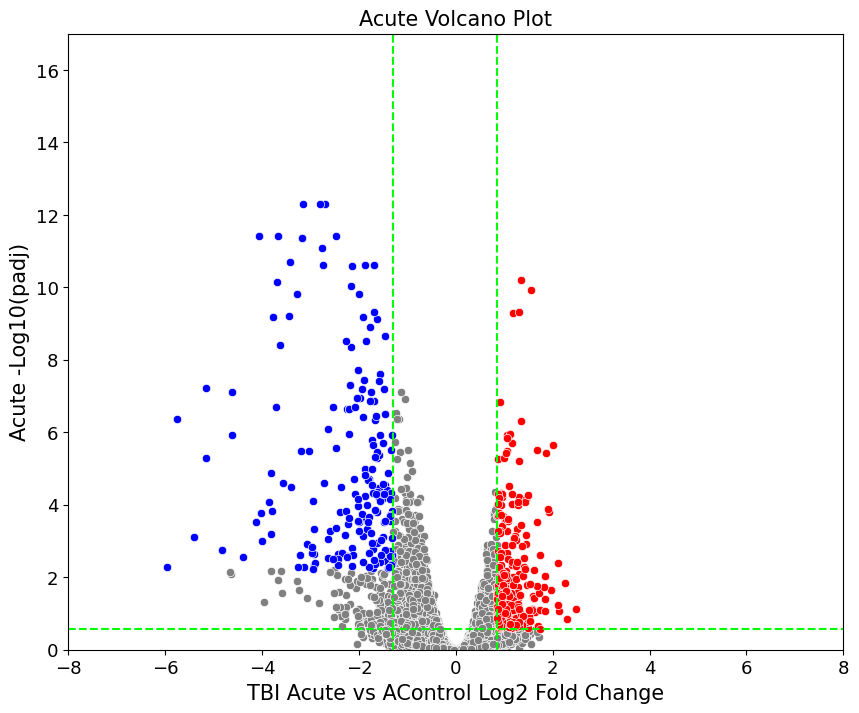

In [65]:
# 조건에 따른 색상 지정
df_acute['color'] = 'gray'  # 기본 색상
df_acute.loc[(df_acute['Acute padj'] < 0.27) & (df_acute['TBI Acute vs AControl Log2 fold change'] > 0.85), 'color'] = 'red'
df_acute.loc[(df_acute['Acute padj'] < 0.006) & (df_acute['TBI Acute vs AControl Log2 fold change'] < -1.3), 'color'] = 'blue'

# Volcano plot
plt.figure(figsize=(10, 8))

# 회색 데이터 포인트 그리기
sns.scatterplot(data=df_acute[df_acute['color'] == 'gray'], x='TBI Acute vs AControl Log2 fold change', y='Acute-log10(padj)', color='gray')
# 파란색 데이터 포인트 그리기
sns.scatterplot(data=df_acute[df_acute['color'] == 'red'], x='TBI Acute vs AControl Log2 fold change', y='Acute-log10(padj)', color='red')
sns.scatterplot(data=df_acute[df_acute['color'] == 'blue'], x='TBI Acute vs AControl Log2 fold change', y='Acute-log10(padj)', color='blue')
plt.xlim(-8, 8)
plt.ylim(0, 17) 


# 임계값 선 추가
plt.axhline(y=-np.log10(0.27), color='lime', linestyle='--')  # p-value 임계값 (예: 0.05)
plt.axvline(x=0.85, color='lime', linestyle='--')  # fold change 임계값 (예: 1)
plt.axvline(x=-1.3, color='lime', linestyle='--')  # fold change 임계값 (예: -1)


# 축 레이블과 제목 추가
plt.xlabel('TBI Acute vs AControl Log2 Fold Change', fontsize=15)
plt.ylabel('Acute -Log10(padj)', fontsize=15)
plt.title('Acute Volcano Plot', fontsize=15)

# 축 눈금 폰트 크기 설정
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# 출력
plt.show()

In [66]:
# Red로 표시된 데이터 포인트의 개수
red_count = df_acute[(df_acute['Acute padj'] < 0.27) & (df_acute['TBI Acute vs AControl Log2 fold change'] > 0.85)].shape[0]

# Blue로 표시된 데이터 포인트의 개수
blue_count = df_acute[(df_acute['Acute padj'] < 0.006) & (df_acute['TBI Acute vs AControl Log2 fold change'] < -1.3)].shape[0]

# 결과 출력
print(f"Red points count: {red_count}")
print(f"Blue points count: {blue_count}")


Red points count: 243
Blue points count: 194


In [43]:
df_acute_up = df_acute[(df_acute['Acute padj'] < 0.27)  & (df_acute['TBI Acute vs AControl Log2 fold change'] > 0.85)]
df_acute_up

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj)
52,Tpd52l1,1.037759,1.596615e-03,0.032635,2.796800,1.486311
59,Alox12,0.988659,4.448360e-05,0.002090,4.351800,2.679843
99,Sox9,0.929786,3.251596e-03,0.056178,2.487903,1.250437
141,Car4,1.101983,2.380571e-07,0.000030,6.623319,4.521848
368,Trappc6a,1.053256,1.310488e-02,0.147631,1.882567,0.830822
...,...,...,...,...,...,...
34584,2810442N19Rik,0.871931,1.496251e-02,0.161929,1.824996,0.790675
35180,Rps13,0.870777,4.809639e-03,0.073387,2.317888,1.134378
35715,H4c14,0.850663,1.112687e-02,0.131702,1.953627,0.880407
36606,Cdk3,1.845368,6.006732e-03,0.085082,2.221362,1.070160


In [44]:
df_acute_down = df_acute[(df_acute['Acute padj'] < 0.006)  & (df_acute['TBI Acute vs AControl Log2 fold change'] < -1.3)]
df_acute_down

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj)
153,Dbh,-1.882431,7.330304e-08,1.045994e-05,7.134878,4.980471
163,Mmp14,-1.859348,3.216492e-06,2.394655e-04,5.492618,3.620757
176,S100a6,-3.338888,3.484043e-33,1.342315e-29,32.457916,28.872146
196,Col6a1,-1.705214,3.371301e-05,1.675971e-03,4.472203,2.775733
201,Timp1,-4.059286,3.042136e-15,3.804098e-12,14.516821,11.419748
...,...,...,...,...,...,...
21137,Fndc1,-1.916211,1.630664e-09,3.807600e-07,8.787636,6.419349
21600,Ecscr,-1.650499,1.541006e-09,3.653606e-07,8.812196,6.437278
24661,Fam174b,-1.734800,7.329532e-08,1.045994e-05,7.134924,4.980471
25948,Gm7332,-1.766555,4.833571e-10,1.375741e-07,9.315732,6.861463


In [45]:
acute_up_list = df_acute_up['gene'].to_list()
acute_down_list = df_acute_down['gene'].to_list()

In [41]:
with open('0.adjusted_acute_up_deg_list.txt', 'w') as file:
    for item in acute_up_list:
        file.write(f"{item}\n")

with open('0.adjusted_acute_down_deg_list.txt', 'w') as file:
    for item in acute_down_list:
        file.write(f"{item}\n")

In [46]:
up_deg = df_acute[(df_acute['Acute padj'] < 0.27) & (df_acute['TBI Acute vs AControl Log2 fold change'] > 0.85)]
down_deg = df_acute[(df_acute['Acute padj'] < 0.006) & (df_acute['TBI Acute vs AControl Log2 fold change'] < -1.3)]
output_up = pd.read_csv('0.adjusted_acute_up.txt', sep='\t', header=None, names=['gene', 'score'])
output_down = pd.read_csv('0.adjusted_acute_down.txt', sep='\t', header=None, names=['gene', 'score'])

merged_up = up_deg.merge(output_up, left_on='gene', right_on='gene')
merged_down = down_deg.merge(output_down, left_on='gene', right_on='gene')

merged_up

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj),score
0,Tpd52l1,1.037759,0.001597,0.032635,2.796800,1.486311,0.010000
1,Alox12,0.988659,0.000044,0.002090,4.351800,2.679843,0.010015
2,Sox9,0.929786,0.003252,0.056178,2.487903,1.250437,0.010025
3,Trappc6a,1.053256,0.013105,0.147631,1.882567,0.830822,0.010032
4,Ddb2,0.902024,0.016363,0.169699,1.786133,0.770321,0.010000
...,...,...,...,...,...,...,...
73,Hba-a2,1.404307,0.000146,0.005217,3.834899,2.282551,0.010028
74,Hba-a1,1.669622,0.000004,0.000299,5.363774,3.524248,0.010000
75,Jund,1.044746,0.000280,0.008654,3.552495,2.062765,0.010000
76,Ctsf,0.950809,0.001341,0.028742,2.872592,1.541490,0.010000


In [48]:
up_deg.head(10)

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj)
52,Tpd52l1,1.037759,1.596615e-03,0.032635,2.796800,1.486311
59,Alox12,0.988659,4.448360e-05,0.002090,4.351800,2.679843
99,Sox9,0.929786,3.251596e-03,0.056178,2.487903,1.250437
141,Car4,1.101983,2.380571e-07,0.000030,6.623319,4.521848
368,Trappc6a,1.053256,1.310488e-02,0.147631,1.882567,0.830822
385,Ddb2,0.902024,1.636316e-02,0.169699,1.786133,0.770321
517,Apoe,1.021283,3.815966e-06,0.000275,5.418396,3.560978
588,Rps11,1.126529,5.361560e-09,0.000001,8.270709,5.946201
638,Dnase2a,1.214791,6.051686e-03,0.085484,2.218124,1.068118
663,Gstm7,0.880287,2.421110e-06,0.000189,5.615985,3.722621


In [49]:
down_deg.head(10)

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj)
153,Dbh,-1.882431,7.330304e-08,1.045994e-05,7.134878,4.980471
163,Mmp14,-1.859348,3.216492e-06,2.394655e-04,5.492618,3.620757
176,S100a6,-3.338888,3.484043e-33,1.342315e-29,32.457916,28.872146
196,Col6a1,-1.705214,3.371301e-05,1.675971e-03,4.472203,2.775733
201,Timp1,-4.059286,3.042136e-15,3.804098e-12,14.516821,11.419748
260,Tubb6,-2.159810,1.377744e-13,9.231485e-11,12.860831,10.034728
267,Col1a1,-1.865668,5.490175e-07,5.835109e-05,6.260414,4.233951
503,Lamb1,-1.849620,7.125976e-12,3.014196e-09,11.147156,8.520829
599,Inmt,-3.063179,2.328184e-05,1.245821e-03,4.632983,2.904544
759,Pgf,-3.720176,1.495673e-31,4.609962e-28,30.825163,27.336303


In [55]:
print(len(up_deg))
print(len(down_deg))

243
194


In [50]:
merged_up.to_csv("/data1/project/eunyi/tbi/0.acute_up_gene_np.csv")
acute_up_gene_np = pd.read_csv("/data1/project/eunyi/tbi/0.acute_up_gene_np.csv")
acute_up_gene_np = acute_up_gene_np[["gene", "score"]]
acute_up_gene_np = acute_up_gene_np.rename(columns={"score": "np_score"})
acute_up_gene_np.to_csv("/data1/project/eunyi/tbi/0.acute_up_gene_np.csv", index=False)
acute_up_gene_np.head(10)

,gene,np_score
0,Tpd52l1,0.010000
1,Alox12,0.010015
2,Sox9,0.010025
3,Trappc6a,0.010032
4,Ddb2,0.010000
5,Apoe,0.010000
6,Rps11,0.010007
7,Dnase2a,0.013246
8,Gstm7,0.010255
9,Gpx6,0.010478


In [51]:
print(len(acute_up_gene_np))

78


In [52]:
merged_down

,gene,TBI Acute vs AControl Log2 fold change,Acute pval,Acute padj,Acute-log10(p_value),Acute-log10(padj),score
0,Dbh,-1.882431,7.330304e-08,1.045994e-05,7.134878,4.980471,0.010009
1,Mmp14,-1.859348,3.216492e-06,2.394655e-04,5.492618,3.620757,0.010004
2,S100a6,-3.338888,3.484043e-33,1.342315e-29,32.457916,28.872146,0.010069
3,Col6a1,-1.705214,3.371301e-05,1.675971e-03,4.472203,2.775733,0.010623
4,Timp1,-4.059286,3.042136e-15,3.804098e-12,14.516821,11.419748,0.010331
...,...,...,...,...,...,...,...
98,Prp2rt,-1.451676,4.005854e-06,2.844895e-04,5.397305,3.545934,0.010000
99,Kl,-1.784991,1.457979e-04,5.213206e-03,3.836249,2.282895,0.010019
100,Lgals1,-1.875470,1.123927e-07,1.546503e-05,6.949262,4.810649,0.010836
101,Flnc,-2.742550,2.944067e-14,2.421411e-11,13.531052,10.615932,0.010011


In [53]:
merged_down.to_csv("/data1/project/eunyi/tbi/0.acute_down_gene_np.csv")
acute_down_gene_np = pd.read_csv("/data1/project/eunyi/tbi/0.acute_down_gene_np.csv")
acute_down_gene_np = acute_down_gene_np[["gene", "score"]]
acute_down_gene_np = acute_down_gene_np.rename(columns={"score": "np_score"})
acute_down_gene_np.to_csv("/data1/project/eunyi/tbi/0.acute_down_gene_np.csv", index=False)
acute_down_gene_np.head(10)

,gene,np_score
0,Dbh,0.010009
1,Mmp14,0.010004
2,S100a6,0.010069
3,Col6a1,0.010623
4,Timp1,0.010331
5,Tubb6,0.010000
6,Col1a1,0.010750
7,Lamb1,0.010578
8,Inmt,0.010000
9,Pgf,0.010086


In [54]:
print(len(acute_down_gene_np))

103


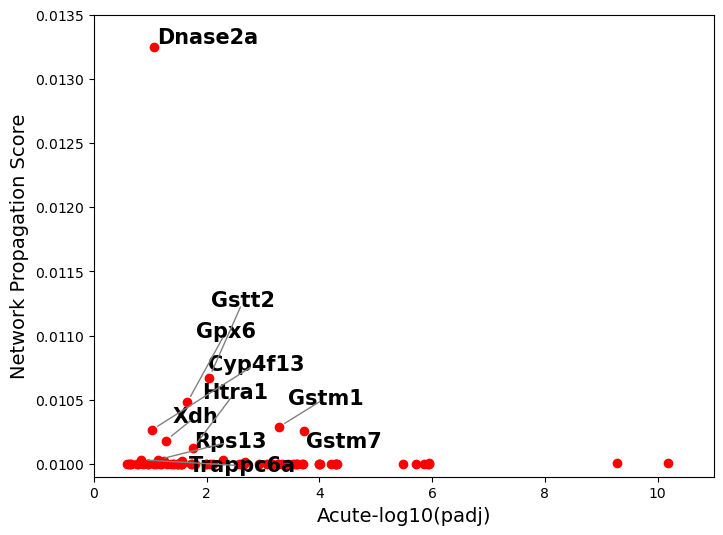

In [49]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 6))
plt.scatter(merged_up['Acute-log10(padj)'], merged_up['score'], color='red')

# x축과 y축 레이블 설정
plt.xlabel('Acute-log10(padj)', fontsize=14)
plt.ylabel('Network Propagation Score', fontsize=14)

# # x축과 y축 범위 통일
plt.xlim(0, 11)

# 공통 y축 범위 설정
y_min = 0.0099
y_max = 0.0135

# y축 범위 설정
plt.ylim(y_min, y_max)


# y축 숫자 형식 설정 (지수 표기법 비활성화)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='y')  # 지수 표기법 비활성화
ax.yaxis.get_major_formatter().set_useOffset(False)

# 상위 10개 유전자에 라벨 추가
top_genes = merged_up.nlargest(10, 'score')
texts = []

for i, row in top_genes.iterrows():
    texts.append(plt.text(row['Acute-log10(padj)'], row['score'], row['gene'], 
                          fontsize=15, color='black', fontweight='bold'))

# 텍스트 간격 자동 조정 및 화살표 조정
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', shrinkA=5, shrinkB=5), 
            only_move={'points':'y', 'text':'y'},  # y축 방향으로만 이동 허용
            expand_text=(1.5, 1.5),  # 텍스트와 포인트 간의 간격 조정
            force_text=(0.5, 0.5))  # 텍스트를 더 강하게 이동시킴

plt.show()




In [50]:
merged_up[merged_up['score'] >= 0.01]['gene']

0      Tpd52l1
1       Alox12
2         Sox9
3     Trappc6a
4         Ddb2
        ...   
73      Hba-a2
74      Hba-a1
75        Jund
76        Ctsf
77       Rps13
Name: gene, Length: 78, dtype: object

In [51]:
merged_up[merged_up['score'] >= 0.01]['gene'].tolist()

['Tpd52l1',
 'Alox12',
 'Sox9',
 'Trappc6a',
 'Ddb2',
 'Apoe',
 'Rps11',
 'Dnase2a',
 'Gstm7',
 'Gpx6',
 'Htra1',
 'Scube2',
 'Cd83',
 'Pltp',
 'Ccn2',
 'Ptprr',
 'Ddc',
 'Madcam1',
 'Hcn2',
 'Castor1',
 'Pomc',
 'Mmp28',
 'Degs2',
 'Irf4',
 'Edn1',
 'Ctnnd2',
 'Col14a1',
 'Tfrc',
 'Bsg',
 'Cyp4f13',
 'Xdh',
 'Aldh1a7',
 'Cbx8',
 'Slc9a2',
 'Edn3',
 'Mme',
 'Hmgcs2',
 'Spaar',
 'Alpl',
 'Sema3c',
 'Ptpru',
 'Prom1',
 'Bcl7a',
 'Pde2a',
 'Mylpf',
 'Gas6',
 'Pdgfd',
 'Dnaja4',
 'Sgpp2',
 'Lmo7',
 'Gstt2',
 'Tle2',
 'Dpp4',
 'Lrrn3',
 'Tctn1',
 'Mboat1',
 'Tgfb2',
 'Htatip2',
 'Plcb2',
 'Ltbp4',
 'Acacb',
 'Itpr3',
 'Notum',
 'Fgfbp1',
 'Msx1',
 'Scn3b',
 'Plcb1',
 'Fam181b',
 'Cbx7',
 'Gstm1',
 'Xcr1',
 'Cxcl12',
 'Fbln2',
 'Hba-a2',
 'Hba-a1',
 'Jund',
 'Ctsf',
 'Rps13']

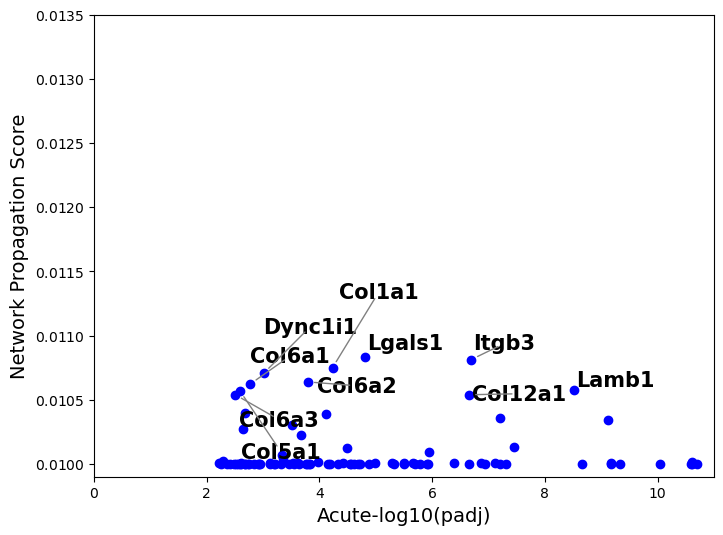

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_down['Acute-log10(padj)'], merged_down['score'], color='blue')

# x축과 y축 레이블 설정
plt.xlabel('Acute-log10(padj)', fontsize=14)
plt.ylabel('Network Propagation Score', fontsize=14)

# # x축과 y축 범위 통일
plt.xlim(0, 11)

# 공통 y축 범위 설정
y_min = 0.0099
y_max = 0.0135

# y축 범위 설정
plt.ylim(y_min, y_max)

# # y축 눈금 설정
# plt.yticks(np.arange(y_min, y_max + 0.0001, 0.0001))

# y축 숫자 형식 설정 (지수 표기법 비활성화)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='y')  # 지수 표기법 비활성화
ax.yaxis.get_major_formatter().set_useOffset(False)

# 상위 10개 유전자에 라벨 추가
top_genes = merged_down.nlargest(10, 'score')
texts = []

for i, row in top_genes.iterrows():
    texts.append(plt.text(row['Acute-log10(padj)'], row['score'], row['gene'], 
                          fontsize=15, color='black', fontweight='bold'))

# 텍스트 간격 자동 조정 및 화살표 조정
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', shrinkA=5, shrinkB=5), 
            only_move={'points':'y', 'text':'y'},  # y축 방향으로만 이동 허용
            expand_text=(1.5, 1.5),  # 텍스트와 포인트 간의 간격 조정
            force_text=(0.5, 0.5))  # 텍스트를 더 강하게 이동시킴

plt.show()

In [54]:
merged_down[merged_down['score'] >= 0.01]['gene'].tolist()

['Dbh',
 'Mmp14',
 'S100a6',
 'Col6a1',
 'Timp1',
 'Tubb6',
 'Col1a1',
 'Lamb1',
 'Inmt',
 'Pgf',
 'Mthfd2',
 'Kit',
 'Prg4',
 'Bmp7',
 'Kcnq1',
 'Aldh1a2',
 'Dcn',
 'Igf1',
 'Avpr1a',
 'Col6a2',
 'Upp1',
 'Itgb3',
 'Serpina3n',
 'Sfrp4',
 'Ednrb',
 'Myc',
 'Alcam',
 'Serpind1',
 'Robo1',
 'Serping1',
 'Cyp1b1',
 'Fkbp5',
 'Sting1',
 'Dpysl3',
 'Ctsw',
 'Aldh18a1',
 'Msr1',
 'Il23a',
 'Il6',
 'Eya1',
 'Igfbp5',
 'Lamc2',
 'Selp',
 'Sele',
 'Lcn2',
 'Col5a1',
 'Il1rn',
 'Cers6',
 'Sema6d',
 'Slc7a11',
 'F3',
 'Plpp3',
 'Pdpn',
 'Acot7',
 'Tnfrsf9',
 'Spp1',
 'Fscn1',
 'Dync1i1',
 'Akr1b8',
 'Lyve1',
 'Angpt2',
 'Eif4ebp1',
 'Dctd',
 'Cdh13',
 'Col12a1',
 'Nt5e',
 'Fkbp1a',
 'Lif',
 'Sema3f',
 'Scn7a',
 'Ccl12',
 'Lum',
 'Inhbb',
 'Serpine1',
 'Kcnk2',
 'Ackr1',
 'Dnah10',
 'Tlr4',
 'Stx11',
 'Atp8b1',
 'Disp2',
 'Gjb6',
 'Pvr',
 'Bace2',
 'Inhba',
 'Piezo2',
 'Irf8',
 'Synpo',
 'Ackr2',
 'Gjb2',
 'Ino80c',
 'Col6a3',
 'Fut4',
 'Gpr55',
 'Ch25h',
 'Prokr2',
 'Map1b',
 'Mapk11',
 'Prp2rt'

## featurecont로 생성

### bowtie로 인덱스 생성 및 정렬 후 featurecount로 테이블 생성한 Subacute 데이터

In [2]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


In [6]:
# 샘플 리스트 및 조건 설정
samples = ["SRR5292045", "SRR5292046", "SRR5292047", "SRR5292048", "SRR5292049"]
conditions = ["TBI-Subacute-Control", "TBI-Subacute-Control", "TBI-Subacute", "TBI-Subacute", "TBI-Subacute"]

# 각 샘플의 count 데이터 로드
count_data = []
for sample in samples:
    file_path = f'/data1/project/eunyi/tbi/data/bowfea_counts/{sample}_counts.txt'
    df = pd.read_csv(file_path, sep='\t', comment='#', index_col=0)
    count_data.append(df.iloc[:, -1])

# 모든 샘플을 하나의 DataFrame으로 결합
counts_df = pd.concat(count_data, axis=1)
counts_df.columns = samples

# 조건 정보를 DataFrame으로 만듦
col_data = pd.DataFrame({'condition': conditions})

# 데이터 확인
print(counts_df.head())
print(col_data)

                    SRR5292045  SRR5292046  SRR5292047  SRR5292048  SRR5292049
Geneid                                                                        
ENSMUSG00000090025           0           0           0           0           0
ENSMUSG00000064842           0           0           0           0           0
ENSMUSG00000051951           2           0           2          32           2
ENSMUSG00000089699           1           0           0           0           0
ENSMUSG00000088390           0           0           0           0           0
              condition
0  TBI-Subacute-Control
1  TBI-Subacute-Control
2          TBI-Subacute
3          TBI-Subacute
4          TBI-Subacute


In [8]:
# 샘플 조건을 DataFrame으로 변환
col_data = pd.DataFrame({'condition': conditions}, index=samples)
col_data['condition'] = pd.Categorical(col_data['condition'])

# DESeq2 분석 수행
dds = DeseqDataSet(counts=counts_df.T, metadata=col_data, design_factors="condition", refit_cooks=True, n_cpus=8)
dds.deseq2()

# DESeq2 통계 분석 및 결과 요약
deseq_stats = DeseqStats(dds)
deseq_stats.summary()

# 결과 추출 및 저장
subacute_results = deseq_stats.results_df[['log2FoldChange', 'pvalue', 'padj']]
subacute_results.columns = ["TBI Subacute vs SControl Log2 fold change", "Subacute pval", "Subacute padj"]

# 결과를 CSV 파일로 저장
subacute_results.to_csv("/data1/project/eunyi/tbi/bowfea_subacute_deseq2.csv")


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.39 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

/data1/project/eunyi/envs/anaconda3/envs/deseq/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 3.55 seconds.

Fitting LFCs...
... done in 2.67 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.83 seconds.



Log2 fold change & Wald test p-value: condition TBI-Subacute-Control vs TBI-Subacute
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                       
ENSMUSG00000090025  0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000064842  0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000051951  6.728225       -3.277453  1.875990 -1.747052  0.080628   
ENSMUSG00000089699  0.216846        1.663598  4.816868  0.345369  0.729817   
ENSMUSG00000088390  0.000000             NaN       NaN       NaN       NaN   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000079820  0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000091501  0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000078539  0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000091917  0.000000             NaN       NaN   

In [10]:
# 분석 결과 데이터 불러오기
subacute_results_fea = pd.read_csv('/data1/project/eunyi/tbi/bowfea_subacute_deseq2.csv', index_col=0)

# 기준을 조정하여 목표 수치에 근접하게 함
up_regulated_criteria_subacute = (subacute_results_fea['TBI Subacute vs SControl Log2 fold change'] > 1.00) & (subacute_results_fea['Subacute padj'] < 0.05)
down_regulated_criteria_subacute = (subacute_results_fea['TBI Subacute vs SControl Log2 fold change'] < -0.8) & (subacute_results_fea['Subacute padj'] < 0.05)

subacute_up = subacute_results_fea[up_regulated_criteria_subacute]
subacute_down = subacute_results_fea[down_regulated_criteria_subacute]

subacute_up_count = len(subacute_up)
subacute_down_count = len(subacute_down)

print(f"Subacute Up: {subacute_up_count}")
print(f"Subacute Down: {subacute_down_count}")

Subacute Up: 29
Subacute Down: 390
